In [104]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms

import cv2
import _sort_contours as SC

#### Single digits

In [158]:
def preprocess(image):
    
    bgr_image = cv2.imread(image)
    gray_image = cv2.imread(image, 0)
    _, threshold = cv2.threshold(gray_image, 150, 160, type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    threshold = cv2.dilate(threshold, kernel, iterations=2)
    threshold = cv2.resize(threshold, (28,28))

    return threshold, bgr_image

In [159]:
class Network(nn.Module):

    def __init__(self):

        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):

        x = x.view(x.shape[0], 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)

        return x

In [4]:
def view_classify(threshold, org_img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), ncols=3)
    ax1.imshow(org_img)
    ax1.set_title('Original Image')

    ax2.imshow(threshold, cmap='gray')
    ax2.set_title('Binary Image')

    ax3.barh(np.arange(10), ps)
    ax3.set_aspect(0.1)
    ax3.set_yticks(np.arange(10))
    ax3.set_title('Probability')
    ax3.set_xlim(0, 1)

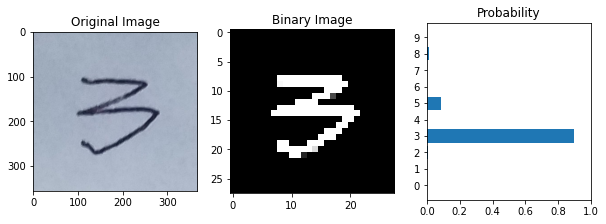

In [160]:
model_path = 'model_mnist_digits.pth' 
model = Network()
model.load_state_dict(torch.load(model_path))
transformer = transforms.Compose([ transforms.ToTensor() ])

image_path = 'images/digits/3.jpg'

threshold, bgr_image = preprocess(image_path)
preds = model(transformer(threshold))
view_classify(threshold, bgr_image, preds)

#### Multiple digits

In [117]:
def preprocess2(image):
    
    bgr_image = cv2.imread(image)
    gray_image = cv2.imread(image, 0)
    _, threshold = cv2.threshold(gray_image, 100, 200, type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    threshold = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel, iterations=3)
    threshold = cv2.dilate(threshold, kernel, iterations=2)

    threshold_copy = threshold.copy() # binary image
    contours, _ = cv2.findContours(threshold_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    left_to_right_contours, _ = SC.sort_contours(sorted_contours, method="left-to-right")

    return threshold, bgr_image, left_to_right_contours

In [131]:
def view_classify2(threshold, bgr_image, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), ncols=3)

    ax1.imshow(threshold, cmap='gray')
    ax1.set_title('Binary Image')

    ax2.imshow(bgr_image, cmap='gray')
    ax2.set_title('Individual Number')

    ax3.barh(np.arange(10), ps)
    ax3.set_aspect(0.1)
    ax3.set_yticks(np.arange(10))
    ax3.set_title('Probability')
    ax3.set_xlim(0, 1)

In [168]:
image_path = 'images/digits/15274609.jpg'
image_path2 = 'images/digits/0123456789.jpg'
image_path3 = 'images/digits/39.jpg'
threshold, bgr_image, list_of_contours = preprocess2(image_path3)

for contour in list_of_contours:
    x,y, w,h = cv2.boundingRect(contour)
    each_contour = threshold[y:y+h, x:x+w]
    each_contour = cv2.resize(each_contour, (28,28))
    preds = model(transformer(each_contour))
    # view_classify2(threshold, each_contour, preds)

    prediction = preds.data.numpy().squeeze()
    prediction = round(max(prediction),1) * 10
    # print(prediction)